In [1]:
# Importing required libraries
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import utils
import scipy.io

In [2]:
# Loading the dataset
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [3]:
x_train_clean, x_train_dist = utils.cifar10_gblur(x_train)

0/50000 images done!
5000/50000 images done!
10000/50000 images done!
15000/50000 images done!
20000/50000 images done!
25000/50000 images done!
30000/50000 images done!
35000/50000 images done!
40000/50000 images done!
45000/50000 images done!
Adding GBLUR done!


In [4]:
x_test_clean, x_test_dist = utils.cifar10_gblur(x_test)

0/10000 images done!
5000/10000 images done!
Adding GBLUR done!


In [9]:
x_train_clean.shape, x_train_dist.shape, x_test_clean.shape, x_test_dist.shape

((250000, 3072), (250000, 3072), (50000, 3072), (50000, 3072))

In [10]:
dims = [32*32*3, 2048, 1024, 512, 64]
# Defining placeholders for Reference and corrupted input
X = tf.placeholder("float", [None, dims[0]], name='X')
tilda_X = tf.placeholder("float", [None, dims[0]], name='tilda_X')

weights = {
    'W1': tf.Variable(tf.random_uniform([dims[0], dims[1]],
                                         -4*tf.sqrt(6. / (dims[0] + dims[1])),
                                          4*tf.sqrt(6. / (dims[0] + dims[1])))),
    'W2': tf.Variable(tf.random_uniform([dims[1], dims[2]],
                                         -4*tf.sqrt(6. / (dims[1] + dims[2])),
                                          4*tf.sqrt(6. / (dims[1] + dims[2])))),
    'W3': tf.Variable(tf.random_uniform([dims[2], dims[3]],
                                         -4*tf.sqrt(6. / (dims[2] + dims[3])),
                                          4*tf.sqrt(6. / (dims[2] + dims[3])))),
    'W4': tf.Variable(tf.random_uniform([dims[3], dims[4]],
                                         -4*tf.sqrt(6. / (dims[3] + dims[4])),
                                          4*tf.sqrt(6. / (dims[3] + dims[4]))))    
}

enc_biases = {
    'b1': tf.Variable(tf.zeros([dims[1]])),
    'b2': tf.Variable(tf.zeros([dims[2]])),
    'b3': tf.Variable(tf.zeros([dims[3]])),
    'b4': tf.Variable(tf.zeros([dims[4]]))    
}

dec_biases = {
    'b4': tf.Variable(tf.zeros([dims[3]])),
    'b3': tf.Variable(tf.zeros([dims[2]])),
    'b2': tf.Variable(tf.zeros([dims[1]])),
    'b1': tf.Variable(tf.zeros([dims[0]]))    
}

def encoder(x):
    hidden = x
    hidden = tf.nn.relu(tf.matmul(hidden, weights['W1']) + enc_biases['b1'])
    hidden = tf.nn.relu(tf.matmul(hidden, weights['W2']) + enc_biases['b2'])
    hidden = tf.nn.relu(tf.matmul(hidden, weights['W3']) + enc_biases['b3'])
    hidden = tf.nn.sigmoid(tf.matmul(hidden, weights['W4']) + enc_biases['b4'])    
    return hidden

def decoder(x):
    output = x
    output = tf.nn.relu(tf.matmul(output, tf.transpose(weights['W4']) 
                                     + dec_biases['b4']))    
    output = tf.nn.relu(tf.matmul(output, tf.transpose(weights['W3']) 
                                     + dec_biases['b3']))
    output = tf.nn.relu(tf.matmul(output, tf.transpose(weights['W2']) 
                                     + dec_biases['b2']))
    output = tf.matmul(output, tf.transpose(weights['W1'])) + dec_biases['b1']
    return output

# hidden vector representation
h = encoder(tilda_X)
# decoded output
y_pred = decoder(h)
y_true = X
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))

In [14]:
# Parameters
training_epochs = 30
batch_size = 256
learning_rate = 0.0001
display_step = 1
examples_to_show = 15

optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 1})
# Launch the graph
with tf.Session(config=config) as sess:
    sess.run(init)
    no_batches = x_train_clean.shape[0]//batch_size
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all the batches
        for i in range(no_batches):
            batch_x, batch_tilda_x = utils.cifar10_next_batch(batch_size,
                                                             x_train_clean,
                                                             x_train_dist)
            # Run optimizer
            _, c = sess.run([optimizer, cost],
                            feed_dict={X: batch_x, tilda_X: batch_tilda_x})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
    print ("Optimization Finished!")

    # Visualizing the weights
    W1 = weights['W1'].eval()
    W2 = weights['W2'].eval()
    W3 = weights['W3'].eval()
    W4 = weights['W4'].eval()    
    scipy.io.savemat('cifar10_saves/params_awgn.mat', {'W1': W1, 'W2': W2, 'W3': W3})
    # Applying encode and decode over test set
    recon = sess.run(y_pred, feed_dict={X: x_test_clean[:examples_to_show],
                                        tilda_X: x_test_dist[:examples_to_show]})

Epoch: 0001 cost= 4067.983642578
Epoch: 0002 cost= 3770.005615234
Epoch: 0003 cost= 3979.521484375
Epoch: 0004 cost= 4272.280761719
Epoch: 0005 cost= 4174.744628906
Epoch: 0006 cost= 4133.561035156
Epoch: 0007 cost= 3924.286132812
Epoch: 0008 cost= 4314.048828125
Epoch: 0009 cost= 4207.466796875
Epoch: 0010 cost= 4173.352539062
Epoch: 0011 cost= 3928.948730469
Epoch: 0012 cost= 4248.405761719
Epoch: 0013 cost= 3877.551757812
Epoch: 0014 cost= 4132.297851562
Epoch: 0015 cost= 4011.086914062
Epoch: 0016 cost= 3894.709228516
Epoch: 0017 cost= 4074.420654297
Epoch: 0018 cost= 4187.365234375
Epoch: 0019 cost= 3810.269287109
Epoch: 0020 cost= 4051.721923828
Epoch: 0021 cost= 4099.650878906
Epoch: 0022 cost= 3772.801025391
Epoch: 0023 cost= 3991.983154297
Epoch: 0024 cost= 4039.092285156
Epoch: 0025 cost= 4046.297119141
Epoch: 0026 cost= 4178.366210938
Epoch: 0027 cost= 4219.556152344
Epoch: 0028 cost= 4105.394531250
Epoch: 0029 cost= 4258.025390625
Epoch: 0030 cost= 4114.179687500
Optimizati

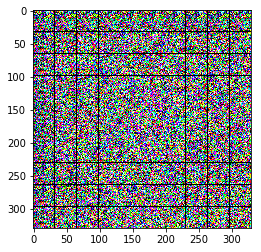

In [15]:
params = scipy.io.loadmat('cifar10_saves/params_awgn.mat')
W1 = params['W1']
vis_w1 = utils.visualize(W1.T, [32, 32], [1, 1], [10, 10], 1)
plt.imshow(vis_w1)
plt.draw()
plt.savefig('cifar10_saves/awgn_weights_vis.png')
plt.show()

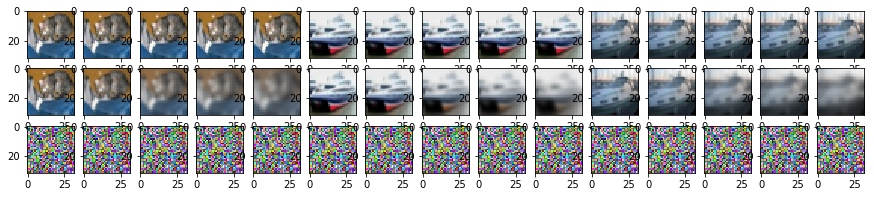

In [16]:
# Compare original images with their reconstructions
f, a = plt.subplots(3, 15, figsize=(15, 3))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_test_clean[i], (32, 32, 3)))
    a[1][i].imshow(np.reshape(x_test_dist[i], (32, 32, 3)))
    a[2][i].imshow(np.reshape(recon[i], (32, 32, 3)))
plt.draw()
plt.savefig('saves/awgn_test_vis.png')
plt.show()